<a href="https://colab.research.google.com/github/Pai-Ya-Ting/Text-mining/blob/main/Text-clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Homework 5 - Text clustering
** Prepare datasets**
Download dataset movie_data_60.csv from google drive


In [ ]:
#download data from google drive
import gdown
url = "https://drive.google.com/uc?id=1o0I46KhBjkW2tdxD-k9NwkhrtQbI6gNF"
gdown.download(url, "movies_genre_60.csv", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1o0I46KhBjkW2tdxD-k9NwkhrtQbI6gNF
To: /content/movies_genre_60.csv
100%|██████████| 491k/491k [00:00<00:00, 65.5MB/s]


'movies_genre_60.csv'

In [ ]:
# load data to pandas data frame
import pandas as pd
import numpy as np

doc_data = pd.read_csv('movies_genre_60.csv', sep=",", header=0 )
movie_titles = doc_data['Title'].tolist()  # convert column Title of panda frame to list
movie_synopses = doc_data['Synopsis'].tolist()
movie_genre = doc_data['Genre'].tolist()
# doc_data

#Step 1:  Pre-Processing text

In [ ]:
# Define function for Lemmatization, remove stopword and feature selection using POS, spacy package
import spacy
def spacy_preprocess (text,lemma= True, pos= True, pos_select = ["VERB", "NOUN", "ADJ","ADV","PART"]):
  # Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
  nlp = spacy.load('en', disable=['parser', 'ner']) # disable parser, ner for faster loading
  # Parse the sentence using the loaded 'en' model object `nlp`
  doc = nlp(text)
    
  if pos== False:
    if lemma== True: text_preprocess= " ".join([token.lemma_.lower() for token in doc if not nlp.vocab[token.text].is_stop])
    if lemma== False:text_preprocess= " ".join([token.text.lower() for token in doc if not nlp.vocab[token.text].is_stop])
  else:
    if lemma== True : text_preprocess= " ".join([token.lemma_.lower() for token in doc if (token.pos_ in pos_select and not nlp.vocab[token.text].is_stop)])
    if lemma== False : text_preprocess= " ".join([token.text.lower() for token in doc if (token.pos_ in pos_select  and not nlp.vocab[token.text].is_stop)])
  # nlp.vocab[token.text].is_stop to remove stopwords
  return text_preprocess

In [ ]:
# Pre-processing data with spacy
from tqdm.notebook import tqdm
movie_synopses_preprocess=[]
for movie in tqdm(movie_synopses):
  movie_preprocess = spacy_preprocess(movie,pos_select = ["VERB", "NOUN", "ADJ"])
  movie_synopses_preprocess+= [movie_preprocess]

#Step 2: Build feature matrix (tf-idf)
**You need to change** the **data_input** below, for example in case no preprocess data: the **data_input = movie_synopses**, in case you want to use preprocess data, the **data_input = movie_synopses_preprocess** 

In [ ]:
#change data input (movie_synopses or movie_synopses_preprocess) here
data_input =movie_synopses # data without preprocess
#data_input =movie_synopses_preprocess  # the data after preprocess text.

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0.1, max_df=0.8, max_features= None)
feature_matrix = vectorizer.fit_transform(movie_synopses).astype(float)
feature_names = vectorizer.get_feature_names() # get feature names
print("number of feature:", len(feature_names))

number of feature: 1131


In [ ]:
vectorizer = TfidfVectorizer(min_df=0.1, max_df=0.8, max_features= None)
feature_matrix_pre = vectorizer.fit_transform(movie_synopses_preprocess).astype(float)
feature_names_pre = vectorizer.get_feature_names() # get feature names
print("number of feature:", len(feature_names_pre))

number of feature: 790


# (a) Does using text preprocessing give a better result? 

From the results below, we conclude that the processed data can get a better result. Therefore, we use preprocessed data in Test 2.

In [ ]:
from sklearn.cluster import KMeans
#function for Kmean clustering
def k_means(feature_matrix, num_clusters=5):
    km = KMeans(n_clusters=num_clusters, n_init=500, random_state = 1,
                max_iter=10000)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters

def get_cluster_data(clustering_obj, doc_data, 
                     feature_names, num_clusters,
                     topn_features=10):

    cluster_details = {}  
    # get cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    # get key features for each cluster
    # get docs belonging to each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index] 
                        for index 
                        in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features
        
        docs = doc_data[doc_data['Cluster'] == cluster_num]['Title'].values.tolist()
        cluster_details[cluster_num]['docs'] = docs
    
    return cluster_details

def print_clusters(cluster_data):
    # print cluster details
    correct = 0
    for cluster_num, cluster_details in cluster_data.items():
        print ('Cluster {} details:'.format(cluster_num))
        print ('-'*20)
        print ('Key features:', cluster_details['key_features'])
        print ('docs in this cluster:')
        label = list(map(lambda x: x[0], cluster_details['docs']))
        correct += sum(np.array(label) == most_frequent(label))
        print (', '.join(cluster_details['docs']))
        print ('='*40)
    print("Purity: ", correct/60)

def most_frequent(List):
    return max(set(List), key = List.count)

# assume that we want to clustering withy k =3
num_clusters = 3
km_obj, km_clusters = k_means(feature_matrix=feature_matrix,
                           num_clusters=num_clusters)

doc_data['Cluster'] = km_clusters

km_cluster_data =  get_cluster_data(clustering_obj=km_obj,
                                 doc_data = doc_data,
                                 feature_names=feature_names,
                                 num_clusters=num_clusters,
                                 topn_features=10)

print_clusters(km_cluster_data)  

Cluster 0 details:
--------------------
Key features: ['from', 'house', 'school', 'home', 'wedding', 'back', 'father', 'love', 'while', 'time']
docs in this cluster:
1.16_The Purge: Election Year (2016), 2.1_No Strings Attached (I) (2011), 2.2_Pretty Woman (1990), 2.3_Coming to America (1988), 2.4_Amélie (2001), 2.5_Blame It on Rio (1984), 2.6_Annie Hall (1977), 2.7_Sex Tape (2014), 2.8_Bridesmaids (I) (2011), 2.9_Arthur (1981), 2.10_Yes Man (2008), 2.11_Summer School (1987), 2.12_Sixteen Candles (1984), 2.13_Knocked Up (2007), 2.14_The Secret of My Success (1987), 2.15_Serendipity (2001), 2.16_One Crazy Summer (1986), 2.17_Clueless (1995), 2.18_Just Friends (I) (2005), 2.19_Just Go with It (2011), 2.20_Dave (1993), 3.3_Birdy (1984), 3.7_Salon Kitty (1976), 3.8_Ivan's Childhood (1962), 3.12_Before the Rain (1994), 3.19_Fugitive Pieces (2007)
Cluster 1 details:
--------------------
Key features: ['camp', 'from', 'war', 'men', 'german', 'soldier', 'sergeant', 'soldiers', 'captain', 'vill

In [ ]:
km_obj, km_clusters = k_means(feature_matrix=feature_matrix_pre,
                           num_clusters=num_clusters)

doc_data['Cluster'] = km_clusters

km_cluster_data_pre =  get_cluster_data(clustering_obj=km_obj,
                                 doc_data = doc_data,
                                 feature_names=feature_names_pre,
                                 num_clusters=num_clusters,
                                 topn_features=10)

print_clusters(km_cluster_data_pre)  

Cluster 0 details:
--------------------
Key features: ['kill', 'shoot', 'try', 'attack', 'creature', 'crew', 'tell', 'escape', 'go', 'run']
docs in this cluster:
1.1_Alien: Resurrection (1997), 1.3_Resident Evil: Apocalypse (2004), 1.4_The Colony (I) (2013), 1.5_They Live (1988), 1.6_Jason X (2001), 1.7_Alien³ (1992), 1.8_DeepStar Six (1989), 1.9_The Meg (2018), 1.10_Resident Evil (2002), 1.11_The Purge: Anarchy (2014), 1.12_Predator 2 (1990), 1.13_Upgrade (2018), 1.14_Underwater (2020), 1.15_The First Purge (2018), 1.16_The Purge: Election Year (2016), 1.17_Morgan (2016), 1.18_Blade (1998), 1.19_Hollow Man (2000), 1.20_Aliens vs. Predator: Requiem (2007)
Cluster 1 details:
--------------------
Key features: ['soldier', 'camp', 'man', 'officer', 'war', 'order', 'kill', 'german', 'boy', 'film']
docs in this cluster:
1.2_Ghosts of Mars (2001), 3.1_The Duellists (1977), 3.2_Paths of Glory (1957), 3.4_Beasts of No Nation (2015), 3.5_Amigo (2010), 3.6_Saving Private Ryan (1998), 3.7_Salon K

# (b) if we limit the max_feature, does it affect the model performance?

In [ ]:
def max_features_selection():
  for n in [300, 400, 500, 600]:
    vectorizer = TfidfVectorizer(min_df=0.1, max_df=0.8, max_features= n)
    feature_matrix_pre = vectorizer.fit_transform(movie_synopses_preprocess).astype(float)
    feature_names_pre = vectorizer.get_feature_names() # get feature names
    print("number of feature:", len(feature_names_pre))

    km_obj, km_clusters = k_means(feature_matrix=feature_matrix_pre,
                            num_clusters=num_clusters)
    doc_data['Cluster'] = km_clusters

    km_cluster_data_pre =  get_cluster_data(clustering_obj=km_obj,
                                    doc_data = doc_data,
                                    feature_names=feature_names_pre,
                                    num_clusters=num_clusters,
                                    topn_features=10)

    print_clusters(km_cluster_data_pre)
    print()


In [ ]:
max_features_selection()

number of feature: 300
Cluster 0 details:
--------------------
Key features: ['kill', 'shoot', 'try', 'attack', 'crew', 'ship', 'creature', 'go', 'tell', 'man']
docs in this cluster:
1.1_Alien: Resurrection (1997), 1.2_Ghosts of Mars (2001), 1.3_Resident Evil: Apocalypse (2004), 1.4_The Colony (I) (2013), 1.5_They Live (1988), 1.6_Jason X (2001), 1.7_Alien³ (1992), 1.8_DeepStar Six (1989), 1.9_The Meg (2018), 1.10_Resident Evil (2002), 1.11_The Purge: Anarchy (2014), 1.12_Predator 2 (1990), 1.13_Upgrade (2018), 1.14_Underwater (2020), 1.15_The First Purge (2018), 1.16_The Purge: Election Year (2016), 1.17_Morgan (2016), 1.18_Blade (1998), 1.19_Hollow Man (2000), 1.20_Aliens vs. Predator: Requiem (2007), 3.14_The Caine Mutiny (1954)
Cluster 1 details:
--------------------
Key features: ['tell', 'love', 'time', 'school', 'relationship', 'friend', 'father', 'wedding', 'take', 'film']
docs in this cluster:
2.1_No Strings Attached (I) (2011), 2.2_Pretty Woman (1990), 2.3_Coming to America (

# (c) Ward Hierarchical clustering

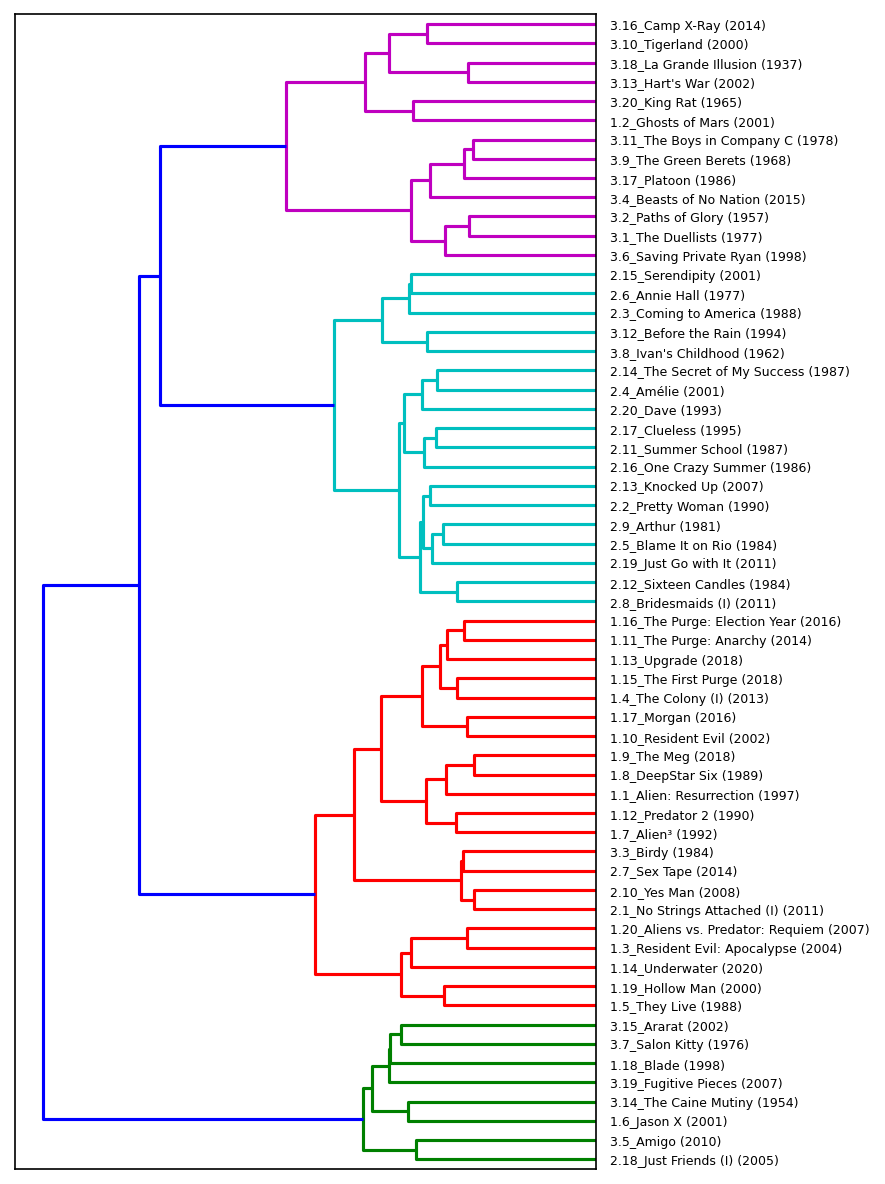

In [ ]:
# Function to form and plot hierarchical clustering

def ward_hierarchical_clustering(feature_matrix):
    
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix

def plot_hierarchical_clusters(linkage_matrix, doc_data, figure_size=(8,12)):
    # set size
    fig, ax = plt.subplots(figsize=figure_size,dpi=150) 
    doc_titles = doc_data['Title'].values.tolist()
    # plot dendrogram
    ax = dendrogram(linkage_matrix, orientation="left", labels=doc_titles)
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom=False,
                    top=False,
                    labelbottom= False)
    plt.tight_layout()
    

import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
import random
from matplotlib.font_manager import FontProperties
from scipy.cluster.hierarchy import ward, dendrogram

# build ward's linkage matrix    
linkage_matrix = ward_hierarchical_clustering(feature_matrix)
plot_hierarchical_clusters(linkage_matrix=linkage_matrix, doc_data=doc_data, figure_size=(6,8))
plt.savefig('hierachical_full.png', dpi=600)
# you can find the file "hierachical_full.png"

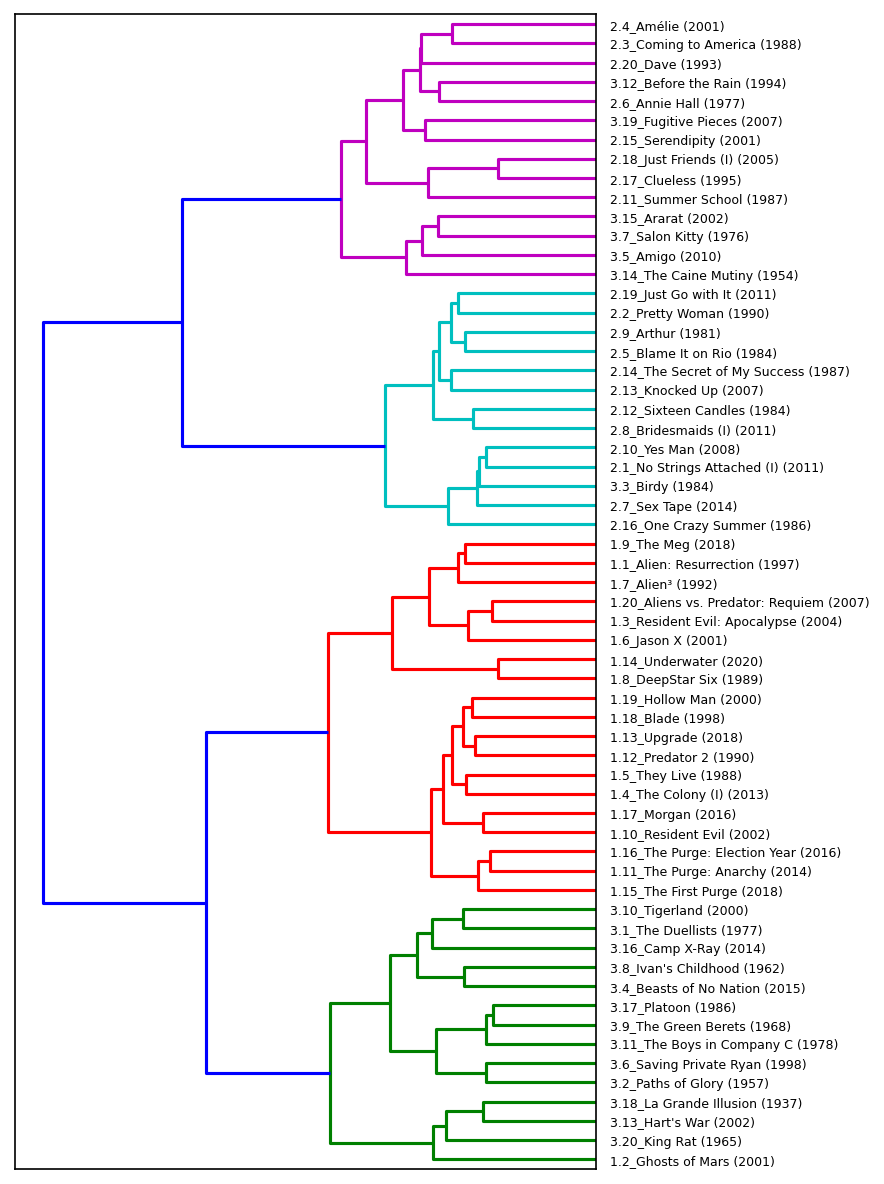

In [ ]:
linkage_matrix_pre = ward_hierarchical_clustering(feature_matrix_pre)
plot_hierarchical_clusters(linkage_matrix=linkage_matrix_pre, doc_data=doc_data, figure_size=(6,8))
plt.savefig('hierachical_full_pre.png', dpi=600)

# (d) SOM Clustering

In [ ]:
!pip install minisom # install minisom for SOM clustering

  Created wheel for minisom: filename=MiniSom-2.2.9-cp37-none-any.whl size=8603 sha256=6085f77e72cc1fe1c98fb612f54276826bc6d7d573e028328bbaf1c52d6a285d
  Stored in directory: /root/.cache/pip/wheels/de/a0/08/5234d6b02b29c561f62b6c985e2eb7d480fb0b92359a8c74e4
Successfully built minisom


In [ ]:
#Step 1 tranining the Neural network 
D = feature_matrix_pre.todense().tolist()
from minisom import MiniSom
max_features=len(feature_names_pre)
xmap_dim =8
ymap_dim =8


som = MiniSom(x=xmap_dim, y= ymap_dim, input_len= max_features, random_seed=1)

import time
start = time.time()

#start training
som.pca_weights_init(D)
som.train_batch(data=D, num_iteration= max_features*200)
#end tranining
end = time.time()
print(end - start,'seconds')

/usr/local/lib/python3.7/dist-packages/minisom.py:370: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


74.08293867111206 seconds


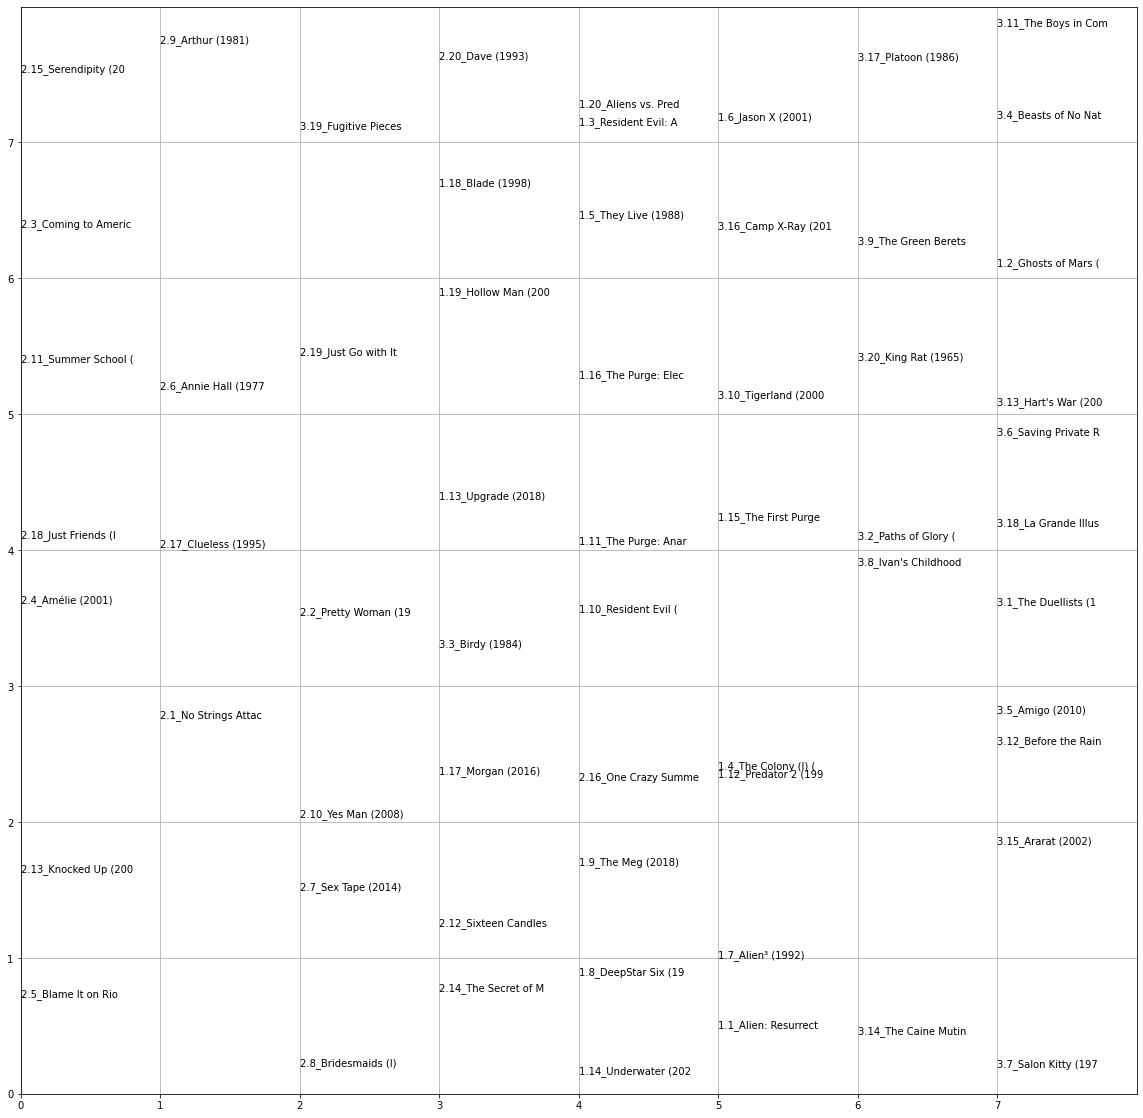

In [ ]:

# show cluster in movies titles
titles=movie_titles

plt.figure(figsize=(20, 20))
for i, (t, vec) in enumerate(zip(titles, D)):
    winnin_position = som.winner(vec)
    plt.text(winnin_position[0], 
             winnin_position[1]+np.random.rand()*0.9, 
             t[0:20], color='black')
    
plt.xticks(range(xmap_dim))
plt.yticks(range(ymap_dim))
plt.grid()
plt.xlim([0, xmap_dim])
plt.ylim([0, ymap_dim])
plt.plot()
plt.savefig('som_titles.png', dpi=300)

In [ ]:
#Movies name, key feature and genre of every cluster
top_keywords =10
weights = som.get_weights()
for i in range(xmap_dim):
   for j in range(ymap_dim):
      keywords_idx = np.argsort(weights[i,j,:])[-top_keywords:]
      keywords = ' '.join([feature_names[k] for k in keywords_idx])
      print('\n')
      print('Cell', i,'-',j, '-','keyword:', keywords)
      movies_t =[]     
      for k, (t, g, vec) in enumerate(zip(movie_titles, movie_genre, D)):
        winnin_position = som.winner(vec)
        if winnin_position[0]==i and winnin_position[1]==j: 
          movies_t+=[t]
          
      print('Titles:', movies_t)



Cell 0 - 0 - keyword: happen claims dinner first anger falling around computer eat actually
Titles: ['2.5_Blame It on Rio (1984)']


Cell 0 - 1 - keyword: eye incident kind let injured captain all attached claims approaches
Titles: ['2.13_Knocked Up (2007)']


Cell 0 - 2 - keyword: points closed attached open carrying live claims approaches off all
Titles: []


Cell 0 - 3 - keyword: leave knocked fall cross frank dinner base hurt friend held
Titles: ['2.4_Amélie (2001)']


Cell 0 - 4 - keyword: drop officer hopes bad fire must gets everything discover ll
Titles: ['2.18_Just Friends (I) (2005)']


Cell 0 - 5 - keyword: dog offer fire else ll briefly class final notices mr
Titles: ['2.11_Summer School (1987)']


Cell 0 - 6 - keyword: comrades dies identity gets claims does friend hope go other
Titles: ['2.3_Coming to America (1988)']


Cell 0 - 7 - keyword: acting moment private any floor going humanity go protect help
Titles: ['2.15_Serendipity (2001)']


Cell 1 - 0 - keyword: knows c